Dataset shape: (31700, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31700 entries, 0 to 31699
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Calories            31325 non-null  float64
 1   Protein             31325 non-null  float64
 2   Fat                 31325 non-null  float64
 3   Carbs               31325 non-null  float64
 4   Sugar               31325 non-null  float64
 5   Fiber               31325 non-null  float64
 6   Sodium              31325 non-null  float64
 7   Cholesterol         31325 non-null  float64
 8   Glycemic_Index      31325 non-null  float64
 9   Water_Content       31325 non-null  float64
 10  Serving_Size        31325 non-null  float64
 11  Meal_Type           31700 non-null  object 
 12  Preparation_Method  31700 non-null  object 
 13  Is_Vegan            31700 non-null  bool   
 14  Is_Gluten_Free      31700 non-null  bool   
 15  Food_Name           31700 

C:\Users\surut\AppData\Local\Temp\ipykernel_14492\2617950642.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=food_counts.index, y=food_counts.values, palette="viridis")


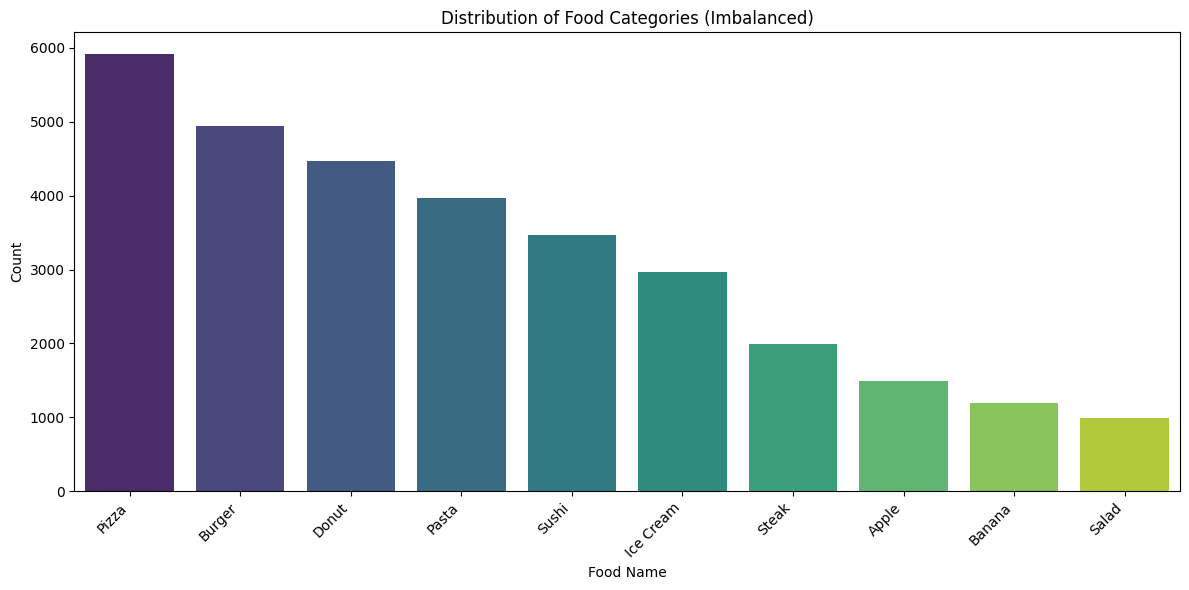


Training set shape: (23540, 15)
Testing set shape: (7847, 15)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay


# --- Load and Initial Inspection ---
df = pd.read_csv(r"food_dataset.csv")


print(f"Dataset shape: {df.shape}")
print(df.info())

# --- Cleaning and Missing Value Handling ---
# Drop duplicate entries
df.drop_duplicates(inplace=True)

# Replace non-standard missing values (e.g., empty strings/spaces) with np.nan
df.replace('', np.nan, inplace=True)
df.replace(' ', np.nan, inplace=True)
df.replace('None', np.nan, inplace=True)

# Check for missing values after robust replacement
print("\n--- Missing Values Check ---")
print(df.isnull().sum()[df.isnull().sum() > 0])

# --- Target Class Distribution ---
food_counts = df['Food_Name'].value_counts()
print("\n--- Target Class Distribution (Food_Name) ---")
print(food_counts)

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=food_counts.index, y=food_counts.values, palette="viridis")
plt.title('Distribution of Food Categories (Imbalanced)')
plt.xlabel('Food Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Separate features (X) and target (y)
X = df.drop('Food_Name', axis=1)
y = df['Food_Name']

# Label Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
target_names = label_encoder.classes_

# Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# --- Preprocessing Pipelines ---

# Numerical Transformer: Impute with median, then scale.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Impute with most frequent, then one-hot encode.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define RANDOM_STATE for reproducibility
RANDOM_STATE = 42

# Split the data (25% test, 75% train)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

,Model,Accuracy,Precision,Recall,F1-Score
4,Support Vector Machine,0.994393,0.994412,0.994393,0.994395
6,XGBoost,0.993246,0.993255,0.993246,0.993244
5,Gradient Boosting Classifier,0.993118,0.993124,0.993118,0.993117
2,Random Forest,0.992226,0.992234,0.992226,0.992227
0,Logistic Regression,0.991844,0.991851,0.991844,0.991842
3,K-Nearest Neighbors,0.991207,0.991229,0.991207,0.991198
1,Decision Tree,0.986619,0.986648,0.986619,0.986623



Best performing model based on accuracy: Support Vector Machine with Accuracy: 0.99439


C:\Users\surut\AppData\Local\Temp\ipykernel_14492\1496804589.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-Score', data=results_df.sort_values(by='F1-Score', ascending=False), palette='viridis')


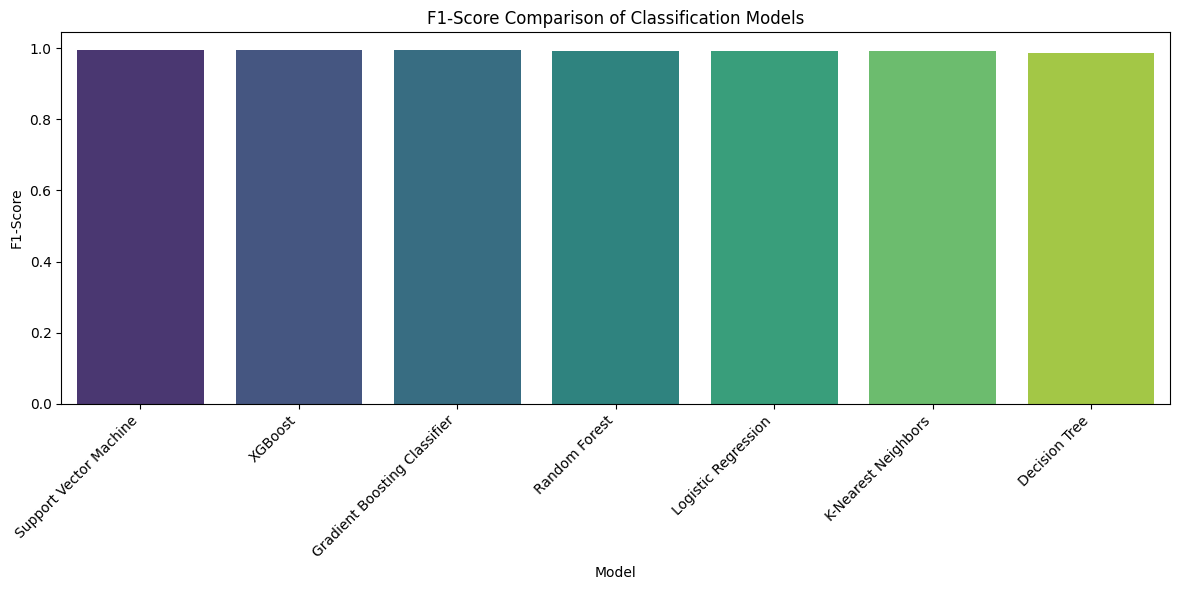

In [3]:
from xgboost import XGBClassifier

# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=RANDOM_STATE),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "XGBoost" : XGBClassifier(random_state=RANDOM_STATE)
}


results = []
best_model_name = ""
best_accuracy = 0

# Train and evaluate models
for name, model in models.items():
    # Create a pipeline: Preprocessor -> Model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate performance
    # Use 'weighted' average due to class imbalance, and zero_division=0
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    # Track the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)

# Display the results DataFrame
display(results_df)

# Print the best performing model based on accuracy
print(f"\nBest performing model based on accuracy: {best_model_name} with Accuracy: {best_accuracy:.5f}")

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score', data=results_df.sort_values(by='F1-Score', ascending=False), palette='viridis')
plt.title('F1-Score Comparison of Classification Models')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

--- Confusion Matrix for Logistic Regression ---


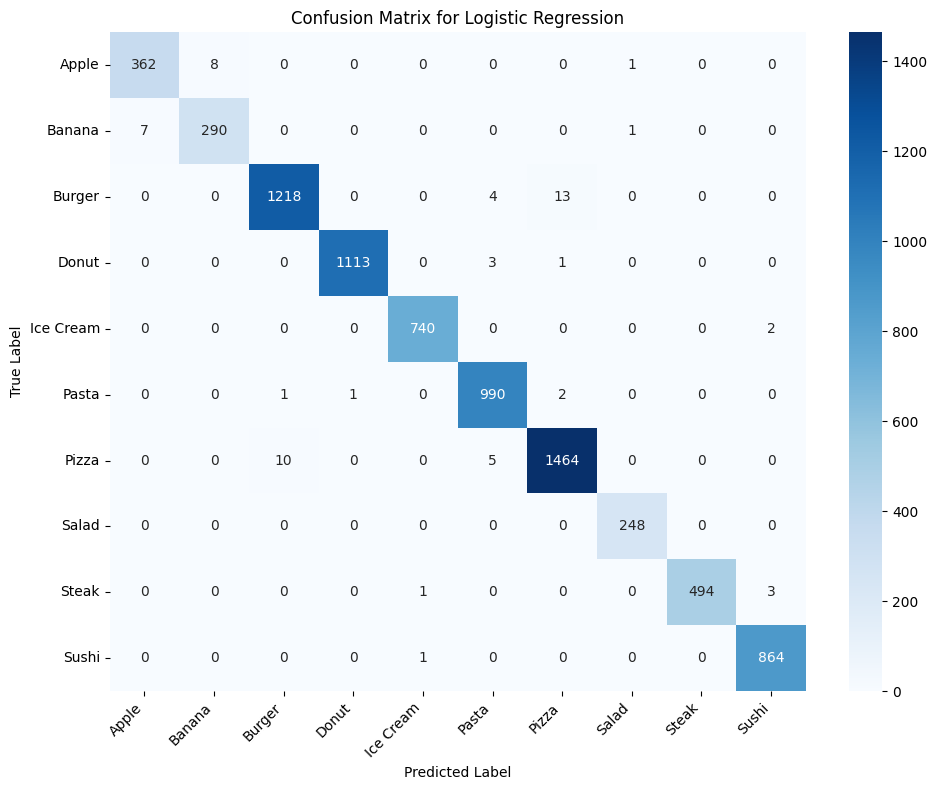

--- Confusion Matrix for Decision Tree ---


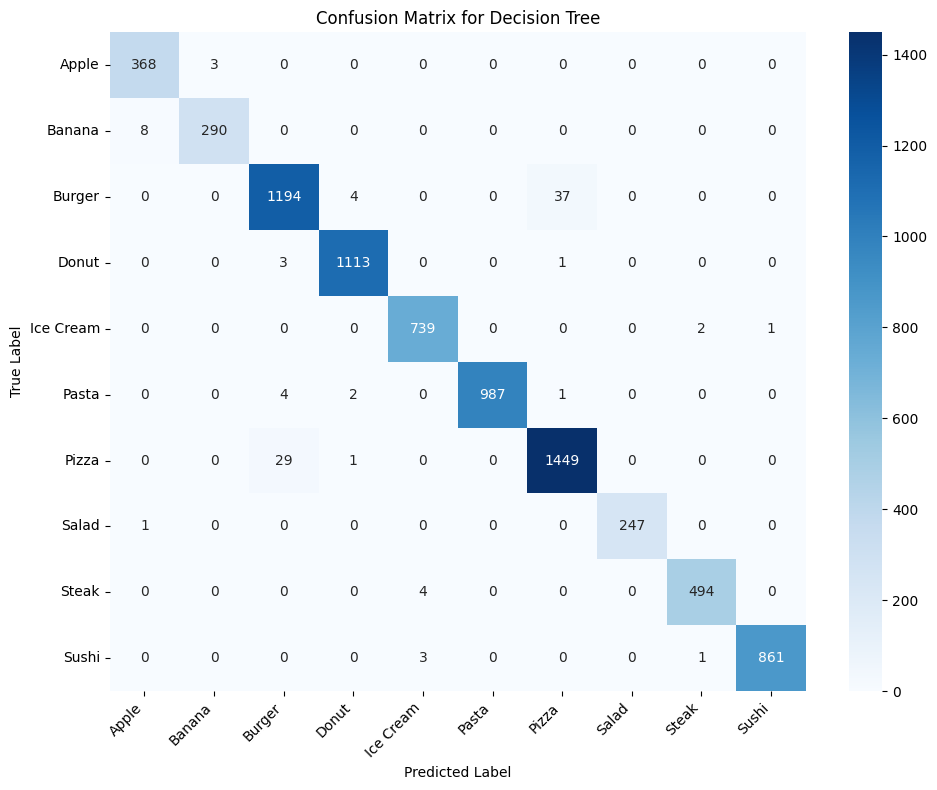

--- Confusion Matrix for Random Forest ---


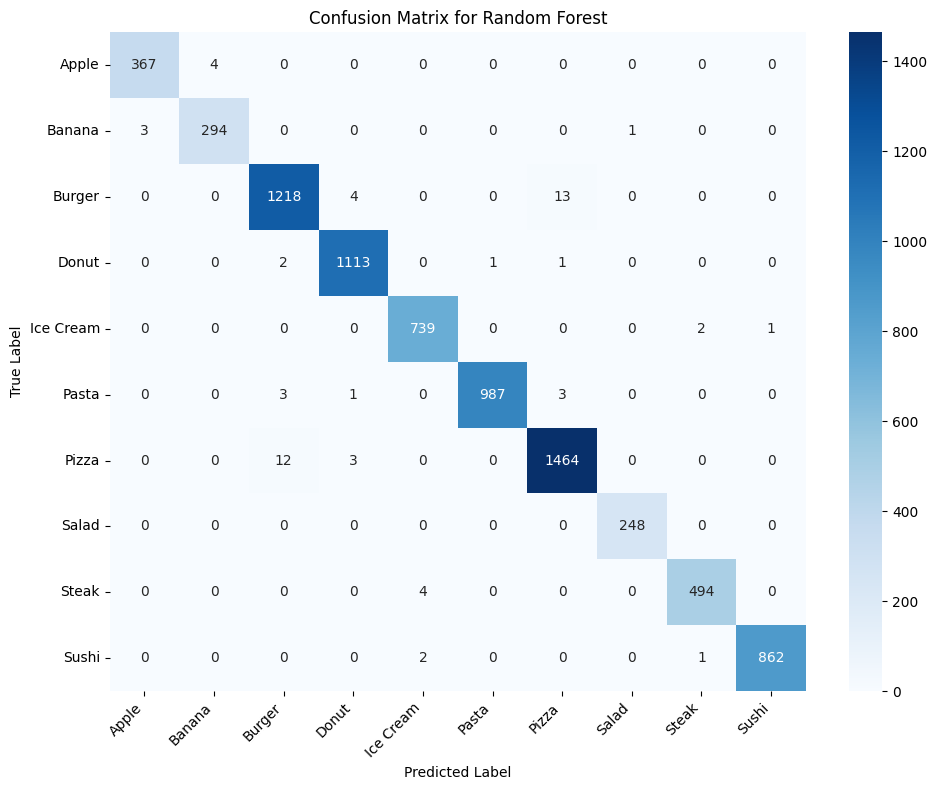

--- Confusion Matrix for K-Nearest Neighbors ---


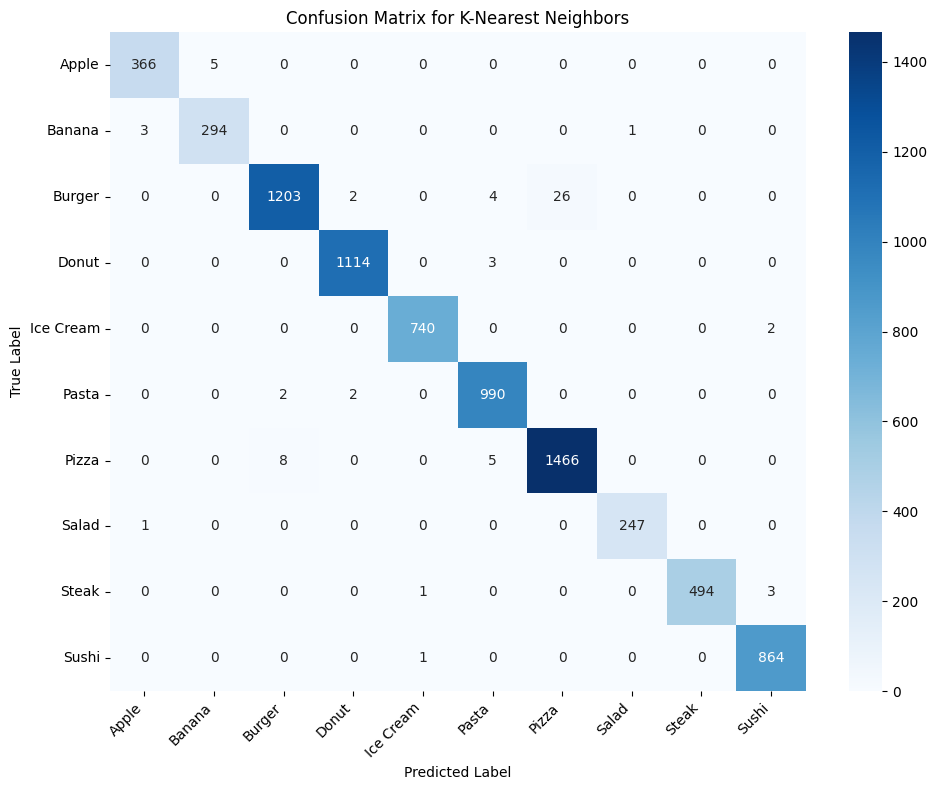

--- Confusion Matrix for Support Vector Machine ---


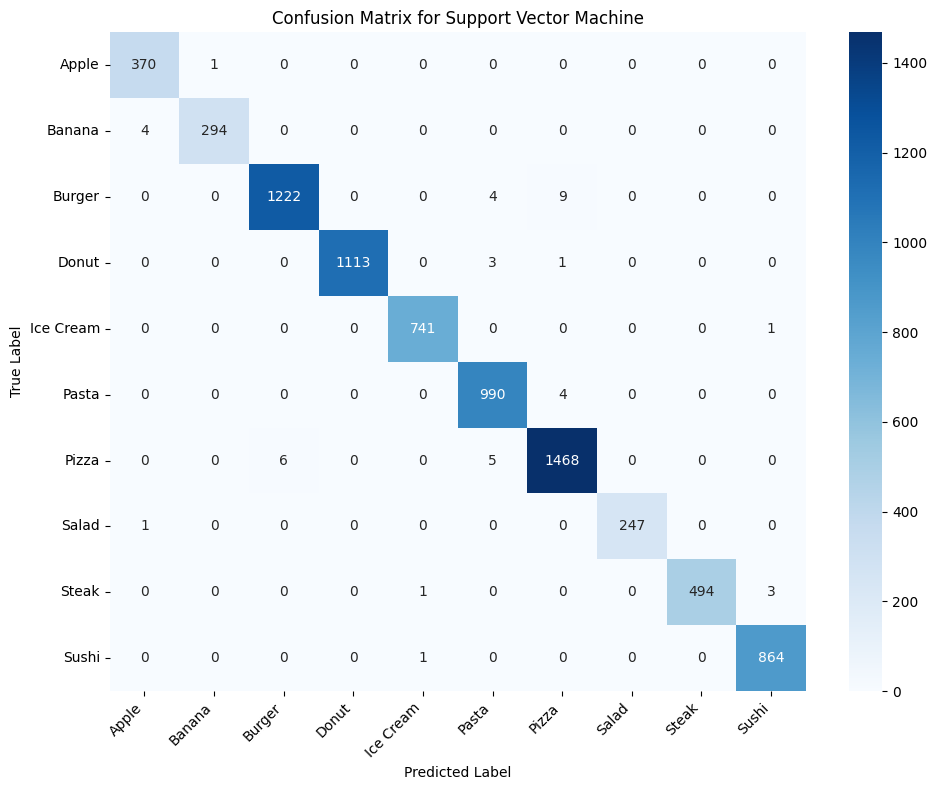

--- Confusion Matrix for Gradient Boosting Classifier ---


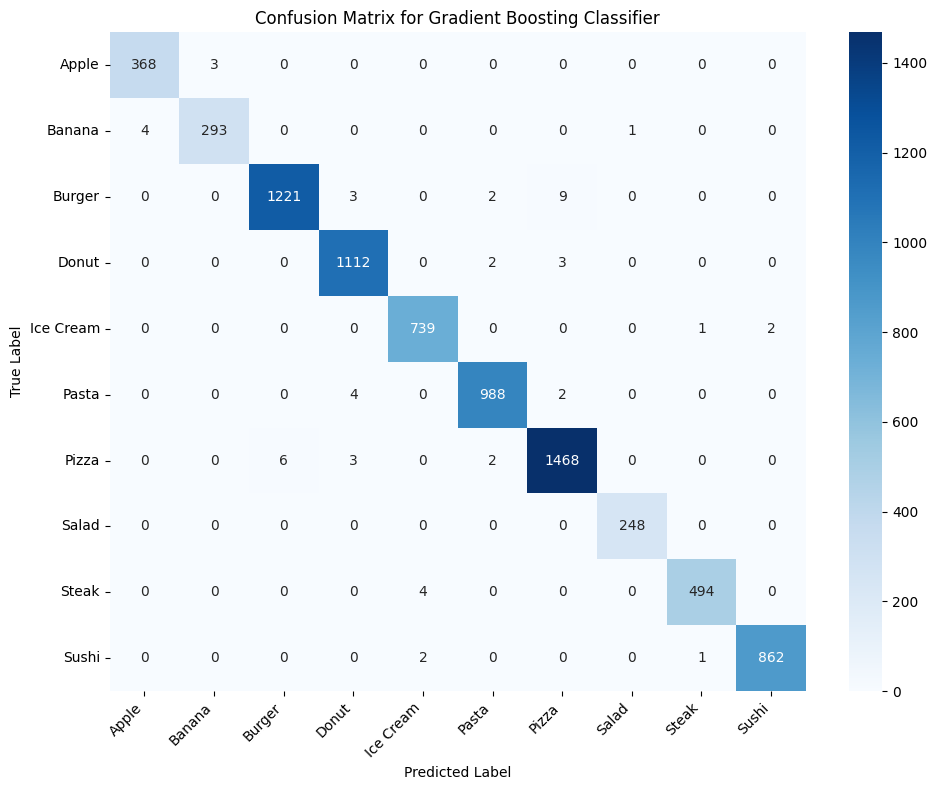

--- Confusion Matrix for XGBoost ---


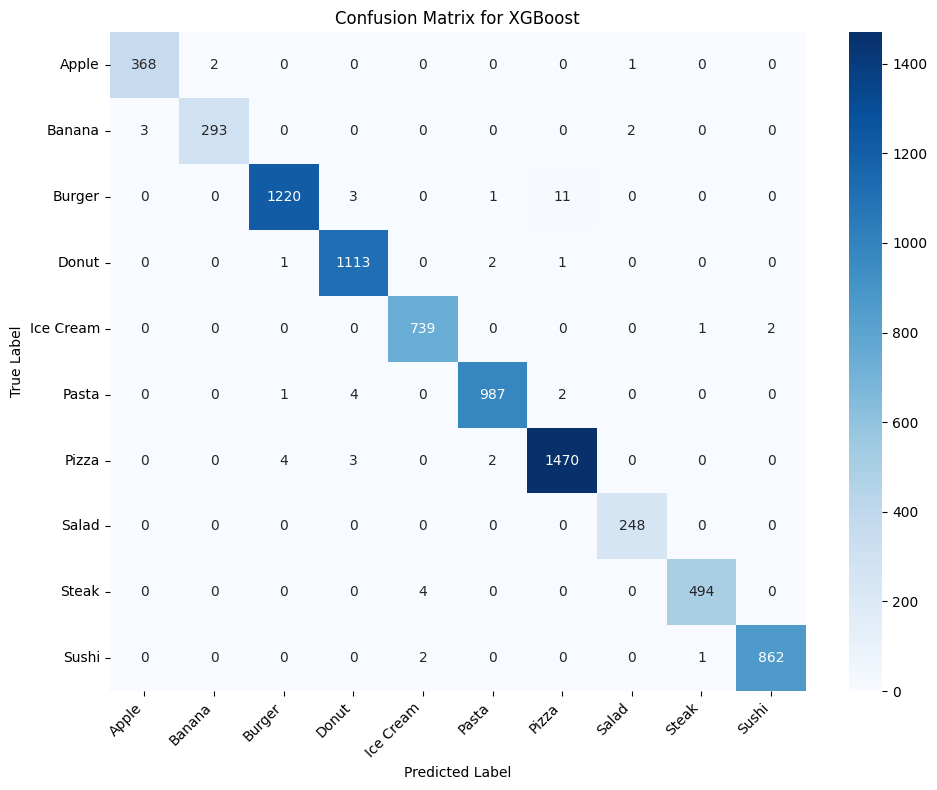

In [4]:
# Iterate through each model and generate its confusion matrix
for name, model in models.items():
    print(f"--- Confusion Matrix for {name} ---")

    # Create a pipeline: Preprocessor -> Model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the pipeline (if not already trained - though they were in the loop)
    # For generating the confusion matrix, we need predictions on the test set.
    # We can use the already trained models from the evaluation loop, but
    # running predict through the pipeline is also correct and ensures preprocessing.
    pipeline.fit(X_train, y_train) # Refit the pipeline for safety

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Decode the predicted labels back to original food names
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=target_names)

    # Display the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Stratified K-Fold object created with 5 splits.
Performing cross-validation for Logistic Regression...
Performing cross-validation for Decision Tree...
Performing cross-validation for Random Forest...
Performing cross-validation for K-Nearest Neighbors...
Performing cross-validation for Support Vector Machine...
Performing cross-validation for Gradient Boosting Classifier...
Performing cross-validation for XGBoost...

--- Cross-Validation Results ---


,Model,CV F1-Scores,Mean CV F1-Score,Std Dev CV F1-Score
4,Support Vector Machine,"[0.9929923294145476, 0.9918820626152293, 0.992...",0.992646,0.000526
2,Random Forest,"[0.9913963302090054, 0.990286684379282, 0.9921...",0.991334,0.000790
5,Gradient Boosting Classifier,"[0.9913940353457863, 0.9914005255478917, 0.991...",0.991334,0.001204
6,XGBoost,"[0.9917155959030258, 0.990282090652427, 0.9918...",0.990951,0.001141
0,Logistic Regression,"[0.9905966645601342, 0.9912464220971985, 0.991...",0.990925,0.000572
3,K-Nearest Neighbors,"[0.9917094628230191, 0.9894790120542747, 0.990...",0.990469,0.000749
1,Decision Tree,"[0.9843823020173462, 0.9834402875241182, 0.985...",0.984356,0.001455


--- Cross-Validation Results for Support Vector Machine ---
CV F1-Scores: [0.99299233 0.99188206 0.99283926 0.99331278 0.99220146]
Mean CV F1-Score: 0.9926
Std Dev CV F1-Score: 0.0005


--- Cross-Validation Results for Random Forest ---
CV F1-Scores: [0.99139633 0.99028668 0.99219639 0.99219158 0.99060088]
Mean CV F1-Score: 0.9913
Std Dev CV F1-Score: 0.0008


--- Cross-Validation Results for Gradient Boosting Classifier ---
CV F1-Scores: [0.99139404 0.99140053 0.99187995 0.9928301  0.98916638]
Mean CV F1-Score: 0.9913
Std Dev CV F1-Score: 0.0012


--- Cross-Validation Results for XGBoost ---
CV F1-Scores: [0.9917156  0.99028209 0.99187593 0.99187277 0.98900844]
Mean CV F1-Score: 0.9910
Std Dev CV F1-Score: 0.0011


--- Cross-Validation Results for Logistic Regression ---
CV F1-Scores: [0.99059666 0.99124642 0.99156952 0.99124083 0.98997151]
Mean CV F1-Score: 0.9909
Std Dev CV F1-Score: 0.0006


--- Cross-Validation Results for K-Nearest Neighbors ---
CV F1-Scores: [0.99170946 0.989479

,Model,CV F1-Scores,Mean CV F1-Score,Std Dev CV F1-Score
4,Support Vector Machine,"[0.9929923294145476, 0.9918820626152293, 0.992...",0.992646,0.000526
2,Random Forest,"[0.9913963302090054, 0.990286684379282, 0.9921...",0.991334,0.000790
5,Gradient Boosting Classifier,"[0.9913940353457863, 0.9914005255478917, 0.991...",0.991334,0.001204
6,XGBoost,"[0.9917155959030258, 0.990282090652427, 0.9918...",0.990951,0.001141
0,Logistic Regression,"[0.9905966645601342, 0.9912464220971985, 0.991...",0.990925,0.000572
3,K-Nearest Neighbors,"[0.9917094628230191, 0.9894790120542747, 0.990...",0.990469,0.000749
1,Decision Tree,"[0.9843823020173462, 0.9834402875241182, 0.985...",0.984356,0.001455



Best performing model based on Mean Cross-Validation F1-Score: Support Vector Machine with Mean CV F1-Score: 0.9926
--- Train-Test Split Results ---


,Model,Accuracy,Precision,Recall,F1-Score
4,Support Vector Machine,0.994393,0.994412,0.994393,0.994395
6,XGBoost,0.993246,0.993255,0.993246,0.993244
5,Gradient Boosting Classifier,0.993118,0.993124,0.993118,0.993117
2,Random Forest,0.992226,0.992234,0.992226,0.992227
0,Logistic Regression,0.991844,0.991851,0.991844,0.991842
3,K-Nearest Neighbors,0.991207,0.991229,0.991207,0.991198
1,Decision Tree,0.986619,0.986648,0.986619,0.986623



--- Cross-Validation Results ---


,Model,CV F1-Scores,Mean CV F1-Score,Std Dev CV F1-Score
4,Support Vector Machine,"[0.9929923294145476, 0.9918820626152293, 0.992...",0.992646,0.000526
2,Random Forest,"[0.9913963302090054, 0.990286684379282, 0.9921...",0.991334,0.000790
5,Gradient Boosting Classifier,"[0.9913940353457863, 0.9914005255478917, 0.991...",0.991334,0.001204
6,XGBoost,"[0.9917155959030258, 0.990282090652427, 0.9918...",0.990951,0.001141
0,Logistic Regression,"[0.9905966645601342, 0.9912464220971985, 0.991...",0.990925,0.000572
3,K-Nearest Neighbors,"[0.9917094628230191, 0.9894790120542747, 0.990...",0.990469,0.000749
1,Decision Tree,"[0.9843823020173462, 0.9834402875241182, 0.985...",0.984356,0.001455



--- F1-Score Comparison (Train-Test vs. Cross-Validation) ---


,Model,Train_Test_F1,Mean CV F1-Score,Difference
0,Support Vector Machine,0.994395,0.992646,0.001749
1,XGBoost,0.993244,0.990951,0.002293
2,Gradient Boosting Classifier,0.993117,0.991334,0.001783
3,Random Forest,0.992227,0.991334,0.000893
4,Logistic Regression,0.991842,0.990925,0.000917
5,K-Nearest Neighbors,0.991198,0.990469,0.000729
6,Decision Tree,0.986623,0.984356,0.002267



--- Observations ---
Comparing the 'Train_Test_F1' and 'Mean CV F1-Score' columns in the table above:
- Models generally show similar F1-scores between the two methods, indicating consistent performance.
- The ranking of models by F1-score is largely consistent.
- Small differences ('Difference' column) exist, which is expected due to the different evaluation methodologies.
- Cross-validation provides a more robust estimate of model performance by averaging scores across multiple folds.


C:\Users\surut\AppData\Local\Temp\ipykernel_14492\3035748227.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Difference', data=comparison_df.sort_values(by='Difference', ascending=False), palette='coolwarm')


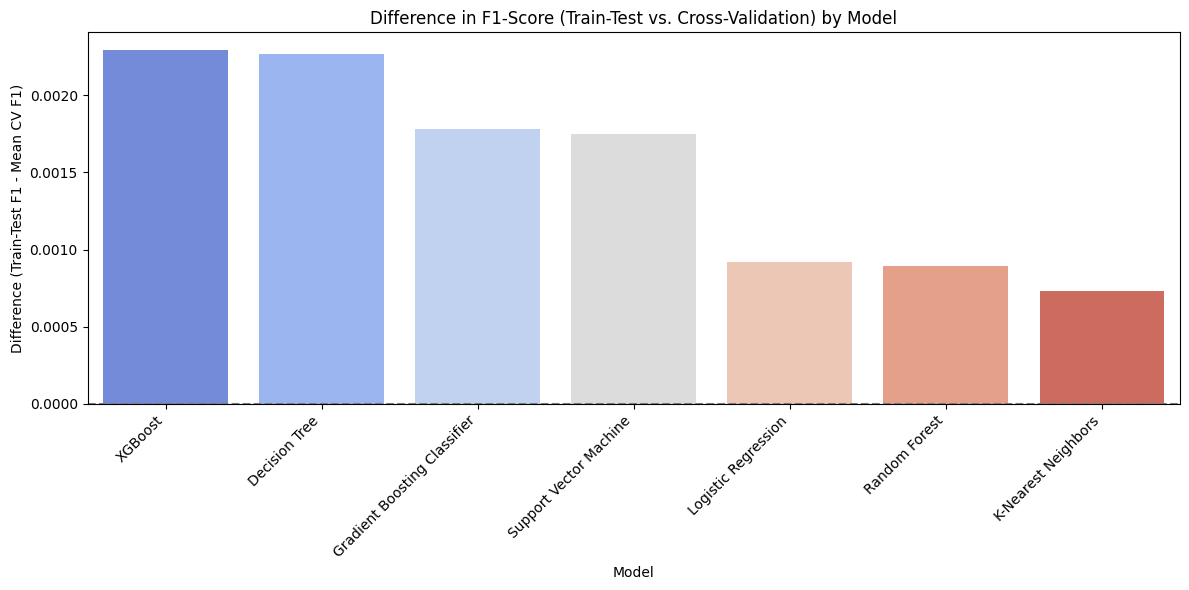

In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Determine the number of splits
n_splits = 5 # A common choice for K-Fold Cross-Validation

# Instantiate StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

print(f"Stratified K-Fold object created with {n_splits} splits.")

# Initialize an empty list to store cross-validation results
cv_results = []

# Loop through each model and perform cross-validation
for name, model in models.items():
    print(f"Performing cross-validation for {name}...")

    # Create a pipeline: Preprocessor -> Model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Perform cross-validation
    # Use 'f1_weighted' for imbalanced datasets
    scores = cross_val_score(pipeline, X, y_encoded, cv=stratified_kfold, scoring='f1_weighted')

    # Store the results
    cv_results.append({
        'Model': name,
        'CV F1-Scores': scores,
        'Mean CV F1-Score': np.mean(scores),
        'Std Dev CV F1-Score': np.std(scores)
    })

# Convert cross-validation results to DataFrame
cv_results_df = pd.DataFrame(cv_results).sort_values(by='Mean CV F1-Score', ascending=False)

print("\n--- Cross-Validation Results ---")
display(cv_results_df)

for index, row in cv_results_df.iterrows():
    print(f"--- Cross-Validation Results for {row['Model']} ---")
    print(f"CV F1-Scores: {row['CV F1-Scores']}")
    print(f"Mean CV F1-Score: {row['Mean CV F1-Score']:.4f}")
    print(f"Std Dev CV F1-Score: {row['Std Dev CV F1-Score']:.4f}")
    print("\n")
    plt.show()

# Display the cross-validation results DataFrame
display(cv_results_df)

# Find the best performing model based on Mean CV F1-Score
best_cv_model = cv_results_df.iloc[0] # cv_results_df is already sorted by Mean CV F1-Score

print(f"\nBest performing model based on Mean Cross-Validation F1-Score: {best_cv_model['Model']} with Mean CV F1-Score: {best_cv_model['Mean CV F1-Score']:.4f}")

print("--- Train-Test Split Results ---")
display(results_df)

print("\n--- Cross-Validation Results ---")
display(cv_results_df)

# Compare F1-Scores
print("\n--- F1-Score Comparison (Train-Test vs. Cross-Validation) ---")
comparison_df = results_df[['Model', 'F1-Score']].rename(columns={'F1-Score': 'Train_Test_F1'})
comparison_df = pd.merge(comparison_df, cv_results_df[['Model', 'Mean CV F1-Score']], on='Model')
comparison_df['Difference'] = comparison_df['Train_Test_F1'] - comparison_df['Mean CV F1-Score']
comparison_df = comparison_df.sort_values(by='Train_Test_F1', ascending=False)

display(comparison_df)

# Note significant differences
print("\n--- Observations ---")
print("Comparing the 'Train_Test_F1' and 'Mean CV F1-Score' columns in the table above:")
print("- Models generally show similar F1-scores between the two methods, indicating consistent performance.")
print("- The ranking of models by F1-score is largely consistent.")
print("- Small differences ('Difference' column) exist, which is expected due to the different evaluation methodologies.")
print("- Cross-validation provides a more robust estimate of model performance by averaging scores across multiple folds.")

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Difference', data=comparison_df.sort_values(by='Difference', ascending=False), palette='coolwarm')
plt.title('Difference in F1-Score (Train-Test vs. Cross-Validation) by Model')
plt.xlabel('Model')
plt.ylabel('Difference (Train-Test F1 - Mean CV F1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.axhline(0, color='grey', linestyle='--') # Add a horizontal line at 0 for reference
plt.show()